tgb - 4/29/2021 - Analyzing the multiple linear regressions and neural networks trained on the cold and warm climate of the aquaplanet simulation

# Imports

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
#import tensorflow.math as tfm
from tensorflow import math as tfm
#import tensorflow_probability as tfp
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
#import cartopy.crs as ccrs
import matplotlib.ticker as mticker
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pickle
import sklearn
from sklearn.linear_model import LinearRegression
from scipy import stats

/nfspool-0/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog


In [2]:
fz = 15
lw = 4
siz = 100
S0 = 320 # Representative mean solar insolation for normalization purposes
S0max = 1410.6442 # Max solar insolation for normalization purposes
SN = S0/100 # Representative target = mean insolation / 4
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YMIN = -1 # Representative value for conserving network
YTEXT = 0.3 # Text placement

In [3]:
plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

# Analysis

## Pickle history file for training on multiple datasets

In [7]:
path_repo = '/export/nfs0home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'

### Multiple Linear Regressions with input rescaling

In [87]:
history_BF = 'PKL_DATA2021_04_26_MLR_hist.pkl'
history_TfromNS = 'PKL_DATA2021_04_26_MLR_RH_TfromNS_LHF_nsDELQ_hist.pkl'
history_BCONS = 'PKL_DATA2021_04_26_MLR_RH_BCONS_LHF_nsDELQ_hist.pkl'

history_BF_W2C = 'PKL_DATA2021_04_27_W2C_MLR_hist.pkl'
history_TfromNS_W2C = 'PKL_DATA2021_04_27_W2C_MLR_RH_TfromNS_LHF_nsDELQ_hist.pkl'
history_BCONS_W2C = 'PKL_DATA2021_04_27_W2C_MLR_RH_BCONS_LHF_nsDELQ_hist.pkl'

In [88]:
h_BF = pickle.load(open(path_repo+history_BF,'rb'))
h_BF = h_BF['hist']

h_TfromNS = pickle.load(open(path_repo+history_TfromNS,'rb'))
h_TfromNS = h_TfromNS['hist']

h_BCONS = pickle.load(open(path_repo+history_BCONS,'rb'))
h_BCONS = h_BCONS['hist']

h_BF_W2C = pickle.load(open(path_repo+history_BF_W2C,'rb'))
h_BF_W2C = h_BF_W2C['hist']

h_TfromNS_W2C = pickle.load(open(path_repo+history_TfromNS_W2C,'rb'))
h_TfromNS_W2C = h_TfromNS_W2C['hist']

h_BCONS_W2C = pickle.load(open(path_repo+history_BCONS_W2C,'rb'))
h_BCONS_W2C = h_BCONS_W2C['hist']

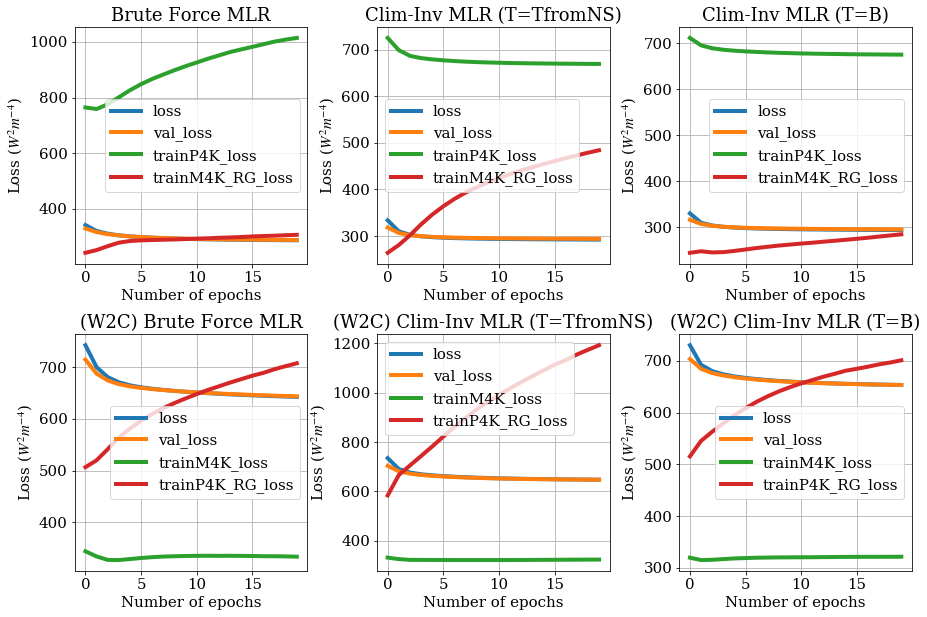

In [89]:
fig,ax = plt.subplots(2,3,figsize=(15,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)

for iax in range(6):
    
    iax_ar = iax//3
    subp = ax[iax_ar][iax-3*iax_ar]
    
    if iax==0: h = h_BF; tit = 'Brute Force MLR'
    elif iax==1: h = h_TfromNS; tit = 'Clim-Inv MLR (T=TfromNS)'
    elif iax==3: h = h_BF_W2C; tit = '(W2C) Brute Force MLR'
    elif iax==4: h = h_TfromNS_W2C; tit = '(W2C) Clim-Inv MLR (T=TfromNS)'
    elif iax==2: h = h_BCONS; tit = 'Clim-Inv MLR (T=B)'
    elif iax==5: h = h_BCONS_W2C; tit = '(W2C) Clim-Inv MLR (T=B)'
    
# Uncomment if you would like to ignore transfer learning across geography    
#     if iax<3: del h['trainM4K_RG_loss']
#     else: del h['trainP4K_RG_loss']
    
    for key in h.keys():
        subp.plot(h[key],label=key)
    subp.legend()
    subp.grid()
    subp.set_title(tit)
    subp.set_xlabel('Number of epochs')
    subp.set_ylabel('Loss ($W^{2}m^{-4}$)')

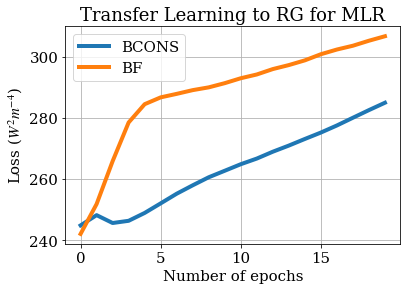

In [99]:
plt.plot(h_BCONS['trainM4K_RG_loss'],label='BCONS')
plt.plot(h_BF['trainM4K_RG_loss'],label='BF')
plt.legend()
plt.title('Transfer Learning to RG for MLR')
plt.xlabel('Number of epochs')
plt.ylabel('Loss ($W^{2}m^{-4}$)')
plt.grid()

### Logistic models with input and output rescalings